In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import numpy as np
import os

from torch.utils.tensorboard import SummaryWriter
import pandas as pd
from collections import Counter
from torch.optim.lr_scheduler import CosineAnnealingLR

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# def save_filenames_to_csv(root_dir, output_csv):
#     # Open the CSV file for writing
#     with open(output_csv, mode='w', newline='', encoding='utf-8') as file:
#         writer = csv.writer(file)
#         writer.writerow(['Folder', 'Filename'])  # Write header
        
#         # Iterate through each folder
#         for folder in os.listdir(root_dir):
#             folder_path = os.path.join(root_dir, folder)
            
#             # Check if it's a directory
#             if os.path.isdir(folder_path):
#                 for filename in os.listdir(folder_path):
#                     file_path = os.path.join(folder_path, filename)
#                     if os.path.isfile(file_path):  # Ensure it's a file
#                         writer.writerow([folder, filename])

# if __name__ == "__main__":
#     root_directory = "./realwaste-main/RealWaste"  # Change this to your dataset's root directory
#     output_csv_file = "dataset.csv"  # CSV file to store results
#     save_filenames_to_csv(root_directory, output_csv_file)
#     print(f"File list saved to {output_csv_file}")


In [ ]:
df = pd.read_csv("../dataset.csv")
df.head()

,Category,Filename
0,Cardboard,Cardboard_1.jpg
1,Cardboard,Cardboard_10.jpg
2,Cardboard,Cardboard_100.jpg
3,Cardboard,Cardboard_101.jpg
4,Cardboard,Cardboard_102.jpg


In [5]:
folder_counts = df["Category"].value_counts()
print(folder_counts)

Category
Plastic                921
Metal                  790
Paper                  500
Miscellaneous Trash    495
Cardboard              461
Vegetation             436
Glass                  420
Food Organics          411
Textile Trash          318
Name: count, dtype: int64


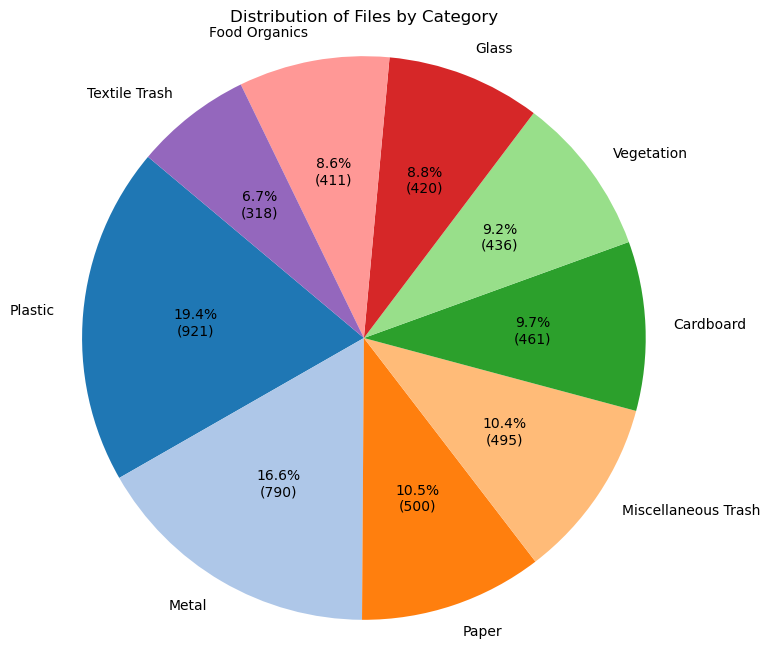

In [6]:
category_counts = df['Category'].value_counts()

# Total count (for percentage calculation)
total = category_counts.sum()

# Custom autopct function
def autopct_format(pct):
    count = int(round(pct * total / 100.0))
    return f"{pct:.1f}%\n({count})"

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    category_counts.values,
    labels=category_counts.index,
    autopct=autopct_format,
    startangle=140,
    shadow=False,
    colors=plt.cm.tab20.colors,  # Use a colormap for colors
   
)
plt.title('Distribution of Files by Category')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# import os
# import shutil
# import pandas as pd
# import uuid
# from sklearn.utils import resample

# # Paths
# image_dir = '../realwaste-main/RealWaste'
# df = pd.read_csv('../dataset.csv')

# # Target size per category
# target_size = 500  

# # Output directories
# balanced_image_dir = 'balanced_images'
# os.makedirs(balanced_image_dir, exist_ok=True)

# # New CSV storage
# balanced_data = []

# # Resample images for each category
# for category in df['Category'].unique():
#     category_df = df[df['Category'] == category]
#     category_dir = os.path.join(image_dir, category)

#     # Create category folder
#     category_balanced_dir = os.path.join(balanced_image_dir, category)
#     os.makedirs(category_balanced_dir, exist_ok=True)

#     # Resampling: Upsample or Downsample
#     if len(category_df) < target_size:
#         # Oversampling: Allow duplicates
#         resampled_category = resample(category_df, replace=True, n_samples=target_size, random_state=42)
#         oversampling = True
#     else:
#         # Downsampling: No duplicates
#         resampled_category = resample(category_df, replace=False, n_samples=target_size, random_state=42)
#         oversampling = False

#     # Copy images & update CSV
#     for idx, row in resampled_category.iterrows():
#         filename = row['Filename']
#         src_path = os.path.join(category_dir, filename)

#         # Check if file exists
#         if not os.path.exists(src_path):
#             print(f"Missing file: {src_path}")
#             continue  

#         # Modify filename for duplicates
#         if oversampling:
#             filename_new = f"{uuid.uuid4().hex}_{filename}"  # Unique filenames for duplicates
#         else:
#             filename_new = filename  # No modification for downsampling

#         dst_path = os.path.join(category_balanced_dir, filename_new)

#         # Copy image
#         shutil.copy(src_path, dst_path)

#         # Store updated CSV row
#         balanced_data.append({"Filename": filename_new, "Category": category})

# # Save new CSV file
# balanced_df = pd.DataFrame(balanced_data)
# balanced_df.to_csv("balanced_dataset.csv", index=False)

# # Verify new dataset distribution
# print("\nBalanced dataset distribution:")
# for category in os.listdir(balanced_image_dir):
#     category_path = os.path.join(balanced_image_dir, category)
#     if os.path.isdir(category_path):
#         print(f"{category}: {len(os.listdir(category_path))} files")

# print("\n✅ New balanced dataset saved as 'balanced_dataset.csv' 🚀")


In [8]:

# # Path to the balanced dataset directory
# balanced_image_dir = 'balanced_images'

# # Initialize total file counter
# total_files = 0

# # Dictionary to store per-category counts
# category_counts = {}

# # Walk through each category folder
# for category in os.listdir(balanced_image_dir):
#     category_path = os.path.join(balanced_image_dir, category)
    
#     # Check if it's a directory
#     if os.path.isdir(category_path):
#         file_count = len(os.listdir(category_path))  # Count files in the category
#         category_counts[category] = file_count
#         total_files += file_count

# # Print per-category counts
# print("\nCategory-wise file count:")
# for category, count in category_counts.items():
#     print(f"{category}: {count}")

# # Print total file count
# print(f"\nTotal files in 'balanced_images': {total_files}")


In [9]:
from sklearn.model_selection import train_test_split

# # Load your dataset
df = pd.read_csv('../balanced_dataset.csv')

# Perform the first split (80% train, 20% val+test)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['Category'], random_state=42)

# Perform the second split (50% val, 50% test) on the temp_df
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Category'], random_state=42)

# # Save the splits to CSV files
# train_df.to_csv('train_set.csv', index=False)
# val_df.to_csv('val_set.csv', index=False)
# test_df.to_csv('test_set.csv', index=False)

# print(f"Training set size: {len(train_df)}")
# print(f"Validation set size: {len(val_df)}")
# print(f"Test set size: {len(test_df)}")


In [10]:
# # Paths
# csv_path = "train_set.csv"  # Path to the CSV file
# source_folder = "./balanced_images"  # Path to the folder with subfolders (containing images)
# destination_folder = "./processed/train"  # Path to the destination folder where new structure will be created

# # Read CSV
# df = pd.read_csv(csv_path)

# # Create destination directories for categories
# categories = df['Category'].unique()
# for category in categories:
#     category_folder = os.path.join(destination_folder, category)
#     if not os.path.exists(category_folder):
#         os.makedirs(category_folder)

# # Iterate through the CSV and copy images to the new folder structure
# for _, row in df.iterrows():
#     category = row['Category']
#     filename = row['Filename']
    
#     # Source path: Find the image in the respective subfolder
#     source_image_path = os.path.join(source_folder, category, filename)
    
#     # Destination path: Copy the image to the new category folder
#     destination_image_path = os.path.join(destination_folder, category, filename)
    
#     # Check if the source image exists
#     if os.path.exists(source_image_path):
#         shutil.copy(source_image_path, destination_image_path)
#         print(f"Copied {filename} to {destination_image_path}")
#     else:
#         print(f"Warning: {source_image_path} does not exist.")

# print("Image copying complete.")


In [11]:
# # Paths
# csv_path = "train_set.csv"  # Path to the CSV file
# source_folder = "processed/train"  # Path to the folder with subfolders (containing images)

# # Read CSV
# df = pd.read_csv(csv_path)

# # Check if all images are present in the respective folders
# missing_images = []

# for _, row in df.iterrows():
#     category = row['Category']
#     filename = row['Filename']
    
#     # Source path: Find the image in the respective subfolder
#     source_image_path = os.path.join(source_folder, category, filename)
    
#     # Check if the image exists
#     if not os.path.exists(source_image_path):
#         missing_images.append((category, filename))

# # Output results
# if missing_images:
#     print("The following images are missing:")
#     for category, filename in missing_images:
#         print(f"Category: {category}, Filename: {filename}")
# else:
#     print("All images are present.")


In [12]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters based on the CoAtNet paper
# Adjusted hyperparameters for smaller dataset (4752 images, 9 categories)
BATCH_SIZE = 32  # Original was 256. Smaller batch size for smaller dataset 
EPOCHS = 50  # Original was 90. Fewer epochs needed for smaller dataset
IMAGE_SIZE = 224  # Standard input size for ResNet
ORIG_IMAGE_SIZE = 524  # Original image size in your dataset
NUM_CLASSES = 9 # Number of classes in the dataset

MODEL_NAME = "resnet50.a1_in1k"  # Resnet model name from timm library

In [ ]:
# Define transforms (Data Augmentation & Normalization)
transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(180),  # Random rotation
    transforms.ColorJitter(hue=0.05, saturation=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

evaluation_transform = transforms.Compose([
    transforms.Resize(288),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])


# Load dataset (RealWaste dataset)
dataset_path = "../processed"  # Path to the processed dataset
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "train"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "val"), transform=evaluation_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "test"), transform=transform)

# DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Check if DataLoader is working
# Get class names
class_names = train_dataset.classes
print(f"Training on {len(train_dataset)} images with {NUM_CLASSES} classes: {class_names}")
print(f"Validation on {len(val_dataset)} images")
print(f"Testing on {len(test_dataset)} images")

Training on 3600 images with 9 classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Validation on 450 images
Testing on 450 images


In [ ]:
def create_resnet50_model(num_classes=9):
    """
    Create a ResNet-50 model using timm with modified output layer for 9 classes
    """
    # Load pretrained=True for transfer learning (better for small datasets)
    model = timm.create_model('resnet50', pretrained=True, num_classes=num_classes)
    return model

def train_and_evaluate(train_loader, val_loader, class_names):
    """
    Train and evaluate ResNet-50 on the custom dataset
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create model
    model = create_resnet50_model(num_classes=len(class_names))
    model = model.to(device)
    
    # Loss function: cross-entropy loss
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer: AdamW with weight decay
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=20)
    
    # Track metrics
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    
    for epoch in range(EPOCHS):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100. * correct / total
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = 100. * val_correct / val_total
        
        # Update learning rate
        scheduler.step()
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch: {epoch+1}/{EPOCHS} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, 'best_resnet50_model.pth')
            print(f"Saved new best model with validation accuracy: {val_acc:.2f}%")
    
    # Save the final model
    torch.save({
        'epoch': EPOCHS,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history,
    }, 'final_resnet50_model.pth')
    
    # Plot training history
    plot_training_history(history)
    
    return model, history

def plot_training_history(history):
    """
    Plot training and validation metrics
    """
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()

In [16]:
train_and_evaluate(train_loader=train_loader, val_loader=val_loader, class_names=class_names)


Using device: cuda


c:\Users\danva\anaconda3\envs\fn-pytorch\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\danva\.cache\huggingface\hub\models--timm--resnet50.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Epoch: 1/50 | Train Loss: 2.0930 | Train Acc: 29.61% | Val Loss: 1.8395 | Val Acc: 58.89% | LR: 0.000099
Saved new best model with validation accuracy: 58.89%
Epoch: 2/50 | Train Loss: 1.5198 | Train Acc: 60.61% | Val Loss: 0.9175 | Val Acc: 72.67% | LR: 0.000098
Saved new best model with validation accuracy: 72.67%
Epoch: 3/50 | Train Loss: 0.9346 | Train Acc: 71.64% | Val Loss: 0.6423 | Val Acc: 81.78% | LR: 0.000095
Saved new best model with validation accuracy: 81.78%
Epoch: 4/50 | Train Loss: 0.7218 | Train Acc: 76.69% | Val Loss: 0.5041 | Val Acc: 83.11% | LR: 0.000090
Saved new best model with validation accuracy: 83.11%
Epoch: 5/50 | Train Loss: 0.6049 | Train Acc: 80.03% | Val Loss: 0.3944 | Val Acc: 87.11% | LR: 0.000085
Saved new best model with validation accuracy: 87.11%
Epoch: 6/50 | Train Loss: 0.5018 | Train Acc: 83.64% | Val Loss: 0.3428 | Val Acc: 89.56% | LR: 0.000079
Saved new best model with validation accuracy: 89.56%
Epoch: 7/50 | Train Loss: 0.4660 | Train Acc: 

KeyboardInterrupt: 

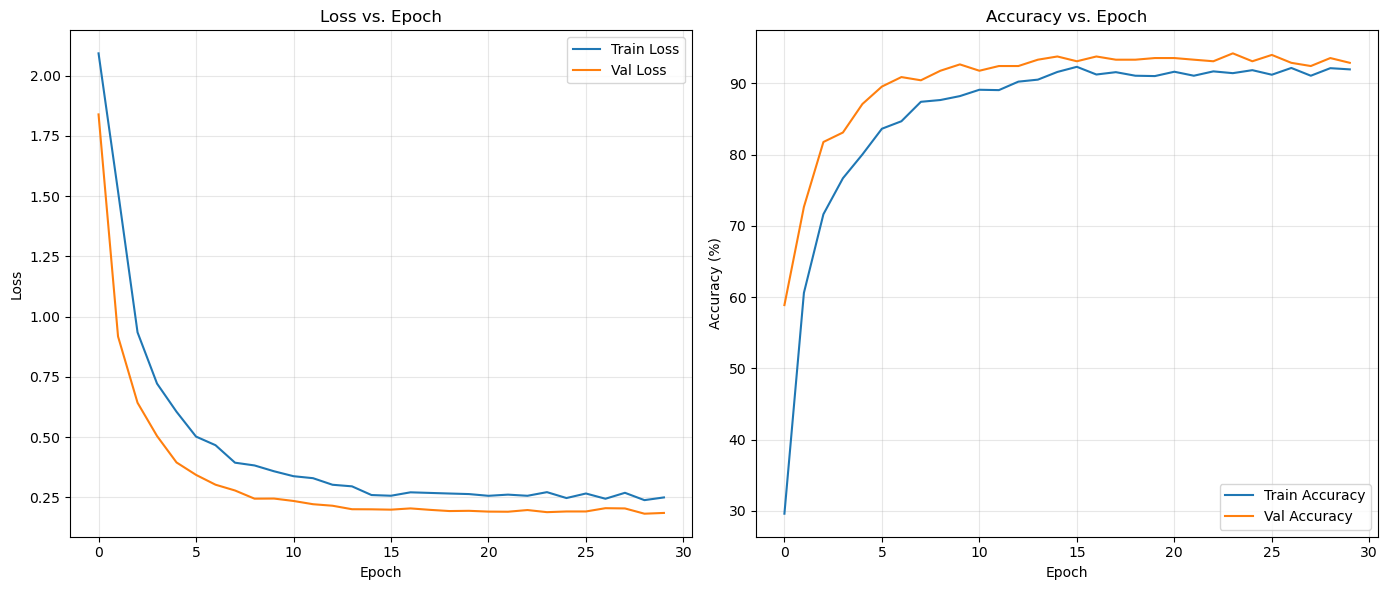

In [2]:
import matplotlib.pyplot as plt

# Extracted values from the training process over 30 epochs
train_loss = [
    2.0930, 1.5198, 0.9346, 0.7218, 0.6049, 0.5018, 0.4660, 0.3934, 0.3820, 0.3578,
    0.3373, 0.3291, 0.3018, 0.2952, 0.2591, 0.2562, 0.2704, 0.2679, 0.2654, 0.2631,
    0.2559, 0.2608, 0.2560, 0.2711, 0.2466, 0.2655, 0.2437, 0.2684, 0.2379, 0.2492
]

val_loss = [
    1.8395, 0.9175, 0.6423, 0.5041, 0.3944, 0.3428, 0.3020, 0.2780, 0.2440, 0.2445,
    0.2345, 0.2210, 0.2147, 0.2002, 0.1998, 0.1984, 0.2036, 0.1976, 0.1926, 0.1936,
    0.1903, 0.1898, 0.1968, 0.1880, 0.1909, 0.1909, 0.2045, 0.2035, 0.1816, 0.1848
]

train_acc = [
    29.61, 60.61, 71.64, 76.69, 80.03, 83.64, 84.69, 87.42, 87.67, 88.22,
    89.11, 89.06, 90.25, 90.53, 91.61, 92.33, 91.25, 91.58, 91.08, 91.03,
    91.64, 91.08, 91.69, 91.44, 91.86, 91.22, 92.17, 91.08, 92.14, 91.97
]

val_acc = [
    58.89, 72.67, 81.78, 83.11, 87.11, 89.56, 90.89, 90.44, 91.78, 92.67,
    91.78, 92.44, 92.44, 93.33, 93.78, 93.11, 93.78, 93.33, 93.33, 93.56,
    93.56, 93.33, 93.11, 94.22, 93.11, 94.00, 92.89, 92.44, 93.56, 92.89
]

epochs = list(range(1, len(train_loss) + 1))

# Plot Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epoch')
plt.grid(True, alpha=0.3)
    
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs. Epoch')
plt.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()
